In [1]:
from typing import Optional
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

#device = 'cuda:0'
#torch.cuda.set_device(0)

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
from torchvision.datasets import MNIST

transform = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


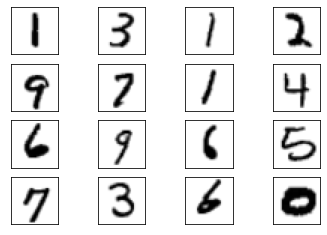

In [3]:
real_samples, mnist_labels = next(iter(trainloader_mnist))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(32, 32), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [4]:
class GeneratorMNISTWGAN(nn.Module):
  def __init__(self, lat_size, hidden=64):
    super(GeneratorMNISTWGAN, self).__init__()
    self.lat_size = lat_size

    self.label_emb = nn.Embedding(10, 10)

    self.net = nn.Sequential(
        nn.ConvTranspose2d(in_channels=lat_size + 10, out_channels=256, kernel_size=4, stride=1, padding=0),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
        nn.Tanh())
    
  # output of main module --> Image (1x32x32)
  def forward(self, x, y):
    y = self.label_emb(y)
    xy = torch.cat((x, y), dim=1)
    xy = xy.view(xy.shape[0], xy.shape[1], 1, 1)
    return self.net(xy)


class DiscriminatorMNISTWGAN(nn.Module):
  def __init__(self, hidden=32):
    super(DiscriminatorMNISTWGAN, self).__init__()

    self.label_emb = nn.Embedding(10, 32*32)

    self.net = nn.Sequential(
        # Image (Cx32x32)
        nn.Conv2d(in_channels=2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=256, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)
    )


  def forward(self, x, y):
    # клиппинг весов
    for p in self.parameters():
      p.data.clamp_(-0.01, 0.01)
    y = self.label_emb(y)
    y = y.view(y.shape[0], 1, 32, 32)
    xy = torch.cat((x, y), dim=1)
    return self.net(xy).view(-1, 1)

In [5]:
def train_gan(tr_dataloader,
              gen, discr, 
              gen_opt, discr_opt, prior, 
              num_epochs, gen_steps, discr_steps,
              discr_params_clip_value=None,
              verbose_num_iters=100,
              data_type='2d'):
    '''
    Имплементирует подсчет лосса для генератора и дискриминатора.
    '''
    #gen.train()
    #discr.train()
    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            # батч реальных объектов
            real_samples, y = batch
            y = y.to(device)
            real_samples = real_samples.to(device)
            batch_size = real_samples.shape[0]

            # таргеты реальных объектов (1) и сгенерированных (0)
            real_samples_labels = torch.ones((batch_size, 1)).to(device)
            gen_samples_labels = torch.zeros((batch_size, 1)).to(device)
            lat_samples_codes = prior.sample((batch_size, ))
            # батч сгенерированных объектов
            gen_samples = gen(lat_samples_codes, y)

            # двойной батч на вход дискриминатору и его реальные таргеты (1 и 0)
            all_samples = torch.cat((real_samples, gen_samples), dim=0)
            all_samples_labels = torch.cat((real_samples_labels, gen_samples_labels), dim=0)

            # выходы дискриминатора на двойном батче
            all_samples_output = discr(all_samples, torch.cat((y, y), dim=0))
            real_samples_output, gen_samples_output = torch.split(all_samples_output, batch_size)

            if (iter_i % (gen_steps + discr_steps)) < gen_steps:
                # генератор учится на gen_samples_output и считает ошибку по real_samples_labels
                gen_opt.zero_grad()
                gen_loss = gen_samples_output.mean(0).view(1)
                gen_loss.backward()
                gen_opt.step()
                gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
                # дискриминатор учится на all_samples и считает ошибку по all_samples_labels = real_samples_labels + generated_samples_labels
                discr_opt.zero_grad()
                discr_loss = (real_samples_output - gen_samples_output).mean(0).view(1)
                discr_loss.backward()
                discr_opt.step()
                discr_loss_trace.append((iter_i, discr_loss.item()))
        
            iter_i += 1
         # Выводим значения функций потерь
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 3, 1)
                plt.xlabel('Iteration')
                plt.ylabel('Generator loss')
                plt.plot([p[0] for p in gen_loss_trace], 
                         [p[1] for p in gen_loss_trace])

                plt.subplot(1, 3, 2)
                plt.xlabel('Iteration')
                plt.ylabel('Discriminator loss')
                plt.plot([p[0] for p in discr_loss_trace], 
                         [p[1] for p in discr_loss_trace], color='orange')
                    
                with torch.no_grad():
                    z = prior.sample((batch_size, ))
                    sampled_mnist = gen(z, y)

                for i in range(16):
                    plt.subplot(4, 12, 12 * (i // 4) + 9 + (i % 4))
                    plt.axis('off')
                    plt.imshow(sampled_mnist[i].detach().cpu().reshape(32, 32), cmap="gray_r")

                plt.show()

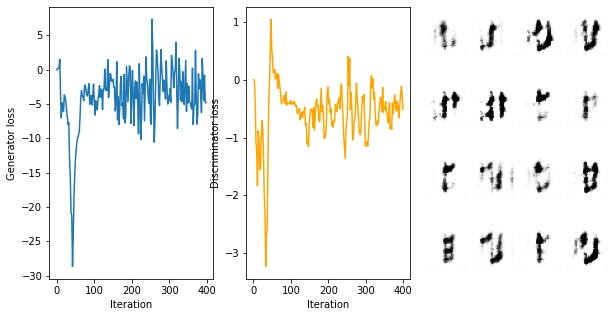

KeyboardInterrupt: ignored

In [6]:
gen_mnist = GeneratorMNISTWGAN(100).to(device)
discr_mnist = DiscriminatorMNISTWGAN().to(device)
prior_mnist = torch.distributions.Normal(torch.zeros(100).to(device), torch.ones(100).to(device))

gen_opt_mnist = optim.RMSprop(gen_mnist.parameters(), lr=3e-4)
discr_opt_mnist = optim.RMSprop(discr_mnist.parameters(), lr=3e-4) 

train_gan(trainloader_mnist, gen_mnist, 
          discr_mnist, gen_opt_mnist, discr_opt_mnist, prior_mnist,
          num_epochs=50, gen_steps=1, discr_steps=1,
          verbose_num_iters=100, data_type='mnist')

torch.float32 torch.int32


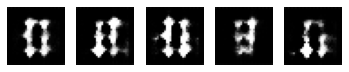

In [7]:
z = prior_mnist.sample((5, ))
labels = torch.Tensor([1, 2, 3, 4, 5]).type(torch.IntTensor).to(device)

print(z.dtype, labels.dtype)
sampled_mnist = gen_mnist(z, labels)

for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')